In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization
import optuna
import matplotlib.pyplot as plt

In [2]:
# Define the dataset and task (Example using a synthetic dataset)
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

In [5]:
# Define model evaluation function
def evaluate_model(model, X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
    return scores.mean()

In [6]:
# Hyperparameter optimization using Bayesian Optimization
def bayesian_optimization(X, y):
    def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf):
        model = RandomForestClassifier(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            min_samples_split=int(min_samples_split),
            min_samples_leaf=int(min_samples_leaf),
            random_state=42
        )
        return evaluate_model(model, X, y)

    pbounds = {
        'n_estimators': (10, 200),
        'max_depth': (1, 20),
        'min_samples_split': (2, 20),
        'min_samples_leaf': (1, 20)
    }

    optimizer = BayesianOptimization(
        f=rf_cv,
        pbounds=pbounds,
        random_state=42
    )
    optimizer.maximize(init_points=10, n_iter=30)

    return optimizer.max

In [7]:
# Hyperparameter optimization using TPE (Optuna)
def tpe_optimization(X, y):
    def objective(trial):
        n_estimators = trial.suggest_int('n_estimators', 10, 200)
        max_depth = trial.suggest_int('max_depth', 1, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
        return evaluate_model(model, X, y)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=40)

    return study.best_trial

In [8]:
# Compare different optimization techniques
def compare_optimizations(X, y):
    random_model = RandomForestClassifier(random_state=42)
    random_score = evaluate_model(random_model, X, y)

    bayes_opt_result = bayesian_optimization(X, y)
    bayes_opt_model = RandomForestClassifier(
        n_estimators=int(bayes_opt_result['params']['n_estimators']),
        max_depth=int(bayes_opt_result['params']['max_depth']),
        min_samples_split=int(bayes_opt_result['params']['min_samples_split']),
        min_samples_leaf=int(bayes_opt_result['params']['min_samples_leaf']),
        random_state=42
    )
    bayes_opt_score = evaluate_model(bayes_opt_model, X, y)

    tpe_opt_result = tpe_optimization(X, y)
    tpe_opt_model = RandomForestClassifier(
        n_estimators=tpe_opt_result.params['n_estimators'],
        max_depth=tpe_opt_result.params['max_depth'],
        min_samples_split=tpe_opt_result.params['min_samples_split'],
        min_samples_leaf=tpe_opt_result.params['min_samples_leaf'],
        random_state=42
    )
    tpe_opt_score = evaluate_model(tpe_opt_model, X, y)

    print(f"Random Model ROC AUC: {random_score:.4f}")
    print(f"Bayesian Optimization ROC AUC: {bayes_opt_score:.4f}")
    print(f"TPE Optimization ROC AUC: {tpe_opt_score:.4f}")

    return random_score, bayes_opt_score, tpe_opt_score

In [9]:
# Visualize learning rate distribution curves
def plot_learning_curves(random_score, bayes_opt_score, tpe_opt_score):
    models = ['Random', 'Bayesian Opt', 'TPE Opt']
    scores = [random_score, bayes_opt_score, tpe_opt_score]
    plt.figure(figsize=(8, 6))
    plt.bar(models, scores, color=['blue', 'green', 'red'])
    plt.xlabel('Model')
    plt.ylabel('ROC AUC Score')
    plt.title('Comparison of Hyperparameter Optimization Techniques')
    plt.show()

# Main execution
random_score, bayes_opt_score, tpe_opt_score = compare_optimizations(X, y)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.9381    | 8.116     | 19.06     | 15.18     | 123.7     |
| 2         | 0.9301    | 3.964     | 3.964     | 3.046     | 174.6     |
| 3         | 0.9395    | 12.42     | 14.45     | 2.371     | 194.3     |
| 4         | 0.9421    | 16.82     | 5.034     | 5.273     | 44.85     |
| 5         | 0.9405    | 6.781     | 10.97     | 9.775     | 65.33     |
| 6         | 0.9438    | 12.63     | 3.65      | 7.259     | 79.61     |
| 7         | 0.9392    | 9.665     | 15.92     | 5.594     | 107.7     |
| 8         | 0.9449    | 12.26     | 1.883     | 12.94     | 42.4      |
| 9         | 0.9229    | 2.236     | 19.03     | 19.38     | 163.6     |
| 10        | 0.9427    | 6.788     | 2.856     | 14.32     | 93.63     |
| 11        | 0.8765    | 1.0       | 1.0       | 20.0      | 10.98     |
| 12        | 0.9425    | 20.0      | 

[I 2024-06-18 17:19:29,372] A new study created in memory with name: no-name-9a9edb4a-f031-43ff-912f-9d00239fb97d
[I 2024-06-18 17:19:29,571] Trial 0 finished with value: 0.91609 and parameters: {'n_estimators': 14, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 13}. Best is trial 0 with value: 0.91609.
[I 2024-06-18 17:19:30,671] Trial 1 finished with value: 0.9216599999999999 and parameters: {'n_estimators': 98, 'max_depth': 2, 'min_samples_split': 15, 'min_samples_leaf': 16}. Best is trial 1 with value: 0.9216599999999999.
[I 2024-06-18 17:19:31,653] Trial 2 finished with value: 0.9390599999999999 and parameters: {'n_estimators': 46, 'max_depth': 18, 'min_samples_split': 14, 'min_samples_leaf': 11}. Best is trial 2 with value: 0.9390599999999999.
[I 2024-06-18 17:19:32,179] Trial 3 finished with value: 0.9339799999999998 and parameters: {'n_estimators': 24, 'max_depth': 11, 'min_samples_split': 15, 'min_samples_leaf': 18}. Best is trial 2 with value: 0.9390599999999999.

Random Model ROC AUC: 0.9471
Bayesian Optimization ROC AUC: 0.9477
TPE Optimization ROC AUC: 0.9469


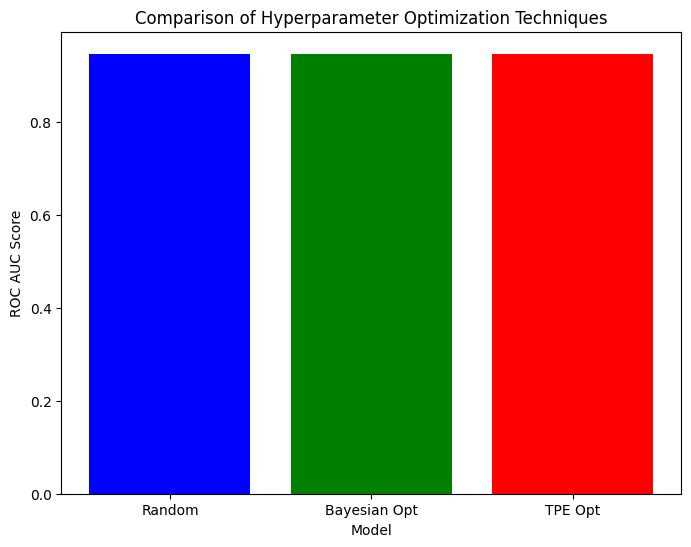

In [10]:
plot_learning_curves(random_score, bayes_opt_score, tpe_opt_score)